# Plant Disease Prediction task
First we will use traditional ML techniques

In [2]:
!pip install opencv-python


In [3]:
import os 
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [4]:
#Setting folder paths
DATA_PATH=r'C:\Users\cyash\Documents\plant-pathology-2020-fgvc7'
CSV_PATH=os.path.join(DATA_PATH,'train.csv')
IMG_FOLDER=os.path.join(DATA_PATH,'images')

In [5]:
#Loading the csv file
df=pd.read_csv(CSV_PATH)
print("Shape of dataset:",df.shape)
print("Firse 5 rows:")
df.head()


Shape of dataset: (1821, 5)
Firse 5 rows:


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


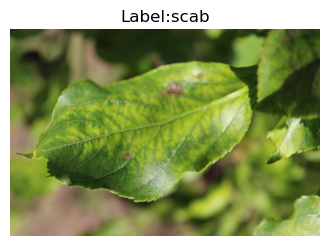

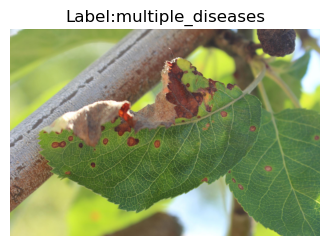

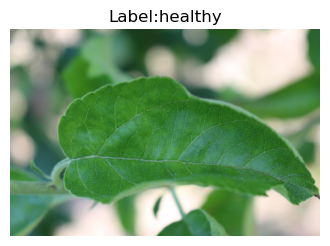

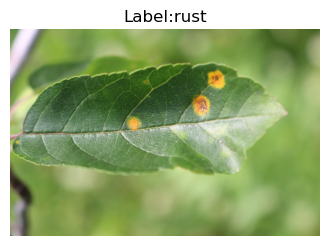

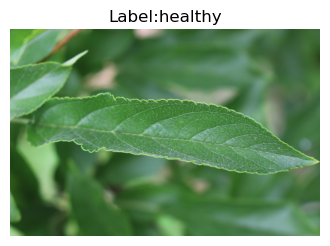

In [6]:
#To display few images from dataset
label_columns=['healthy','multiple_diseases','rust','scab']
for i in range(5):
    image_id=df.loc[i,'image_id']
    #finding column that has a value of 1 
    label_id=df.loc[i,label_columns].idxmax()
    img_path=os.path.join(IMG_FOLDER,image_id+'.jpg')

    #load image using opencv
    img=cv2.imread(img_path)
    if img is None:
        print(f"Image not found at {img_path}")
        continue
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    #show image using matplotlib
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"Label:{label_id}")
    plt.axis('off')
    plt.show()


In [7]:
#getting the numerical features ready for now on 
import numpy as np 
def extract_color_histogram(image,bins=(16,16,16)):
    """
    image:Rgb image as numpy array 
    bins:number of bins per channel 
    returns a 1d array wit concatenated histograms for r,g,b channels 
    """
    #split into R,G,B 
    R=image[:,:,0]
    G=image[:,:,1]
    B=image[:,:,2]

    #computing histograms 
    hist_R=cv2.calcHist([R],[0],None,[bins[0]],[0,256]).flatten()
    hist_G=cv2.calcHist([G],[0],None,[bins[1]],[0,256]).flatten()
    hist_B=cv2.calcHist([B],[0],None,[bins[2]],[0,256]).flatten()

    #normalise histograms
    hist_R /=np.sum(hist_R)
    hist_G /=np.sum(hist_G)
    hist_B /=np.sum(hist_B)

    #concatenate all
    hist_features=np.concatenate([hist_R,hist_G,hist_B])
    return hist_features

In [8]:
X=[] #feature list 
y=[] #label list
for i in range(len(df)):
    image_id=df.loc[i,'image_id']
    label=df.loc[i,label_columns].idxmax(); #get label string
    img_path=os.path.join(IMG_FOLDER,image_id+'.jpg')
    img=cv2.imread(img_path)
    if img is None:
        continue
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128)) # resize for consistency 
    features= extract_color_histogram(img)
    X.append(features)
    y.append(label)

In [9]:
X=np.array(X)
y=np.array(y)
print("Feature matrix shape:",X.shape)
print("Labels shape:",y.shape) 

Feature matrix shape: (1821, 48)
Labels shape: (1821,)


In [10]:
#label encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_encoded=le.fit_transform(y)
print("label classes:",le.classes_)
print("First 5 encoded labels:",y_encoded[:5])
#now we have X and y_encoded ready for ml models

label classes: ['healthy' 'multiple_diseases' 'rust' 'scab']
First 5 encoded labels: [3 1 0 2 0]


In [11]:
#train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_encoded,test_size=0.2,random_state=42,stratify=y_encoded)
print(f"Training samples:{len(X_train)},Test samples: {len(X_test)}")

Training samples:1456,Test samples: 365


In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report

#initialize svm with basic parameters
model=SVC(kernel='rbf',C=1,gamma='scale',random_state=42)

#training 
model.fit(X_train,y_train)

#predict on test data
y_pred=model.predict(X_test)

#evaluation of accuracy
acc=accuracy_score(y_test,y_pred)
print(f"SVM accuracy on test set: {acc:.2f}")

# classification report
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))


SVM accuracy on test set: 0.55

Classification report:

                   precision    recall  f1-score   support

          healthy       0.58      0.51      0.55       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.54      0.55      0.55       125
             scab       0.54      0.66      0.59       119

         accuracy                           0.55       365
        macro avg       0.42      0.43      0.42       365
     weighted avg       0.53      0.55      0.54       365



I experimented with SVM using basic color histograms and found it achieved ~55% accuracy, highlighting that color features alone are insufficient. 
This motivated me to explore more robust models (Random Forest, XGBoost) 
and richer feature sets (texture, shape).
SVM here has hit performance ceiling , because plant diseases are not just color problems, they involve texture ,spots,leafs,edge patterns.
SVM works best when features are stronga and discriminative, right now we gave it basic color data only.


In [13]:
#Using random forest here

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

#initialize random forest
rf_model=RandomForestClassifier(n_estimators=100,random_state=42)

#train the model
rf_model.fit(X_train,y_train)

#predict on test set 
y_pred_rf=rf_model.predict(X_test)

#evaluate performace 
rf_acc=accuracy_score(y_test,y_pred_rf)
print(f"Random forest accuracy on test set: {rf_acc:.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred_rf,target_names=le.classes_))

Random forest accuracy on test set: 0.59

Classification Report:

                   precision    recall  f1-score   support

          healthy       0.61      0.59      0.60       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.58      0.63      0.61       125
             scab       0.59      0.64      0.62       119

         accuracy                           0.59       365
        macro avg       0.45      0.47      0.46       365
     weighted avg       0.56      0.59      0.58       365



Random forest gave ~59 % accuracy, slighty better than SVM and is typical when we are using basic color features only and when we have a small imbalanced class(multiple_diseases).
This means random forest can handle noisy,simple features slightly better than SVM.
The multiple_class remains hard , class needs either
1)better features
2)A method to deal with over sampling.

Both SVM and Random Forest struggle with multiple_diseases due to class imbalance and insufficiently descriptive features (only color). SVM’s reliance on clear feature separation results in total failure for this class, while Random Forest’s bagging approach slightly mitigates this but not enough. This motivated me to explore texture features and models like XGBoost that handle noise and imbalance better.


In [14]:
!pip install xgboost

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

#intialize XGBoost classsifier
xgb_model=XGBClassifier(n_estimators=100,learning_rate=0.1,use_label_encoder=False,eval_metric='mlogloss',random_state=42)

#train on training data
xgb_model.fit(X_train,y_train)

#predict on test data
y_pred_xgb=xgb_model.predict(X_test)

#evaluate accuracy
xgb_acc=accuracy_score(y_test,y_pred_xgb)
print(f"accuracy of xgb on test set:{xgb_acc:.2f}")
print("\nclassification report:\n")
print(classification_report(y_test,y_pred_xgb,target_names=le.classes_)) 


C:\Users\cyash\anacondaprojects\sample_project1\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:55:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


accuracy of xgb on test set:0.59

classification report:

                   precision    recall  f1-score   support

          healthy       0.57      0.53      0.55       103
multiple_diseases       0.00      0.00      0.00        18
             rust       0.60      0.67      0.63       125
             scab       0.60      0.65      0.62       119

         accuracy                           0.59       365
        macro avg       0.44      0.46      0.45       365
     weighted avg       0.56      0.59      0.58       365



On color features alone, I tested SVM, Random Forest, and XGBoost. Performance plateaued around ~59%, highlighting the limitations of color histograms for this dataset. This clearly showed the need to engineer better features.
Now we will move with texture feature extraction 


In [16]:
!pip install scikit-image


In [17]:
#LBP feature extraction
from skimage.feature import local_binary_pattern

def extract_lbp_features(image,numPoints=24,radius=8,bins=10):
    #Convert image to grayscale for texture analysis
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    #compute lbp
    lbp=local_binary_pattern(gray,numPoints,radius,method="uniform")

    #compute historgram of LBP 
    (hist,_)=np.histogram(lbp.ravel(),bins=bins,range=(0,lbp.max()))

    #normalize histogram
    hist=hist.astype("float")
    hist/=(hist.sum()+ 1e-6)
    return hist

In [18]:
X_combined=[]
y_combined=[]

for i in range(len(df)):
    image_id=df.loc[i,'image_id']
    label=df.loc[i,label_columns].idxmax()

    img_path=os.path.join(IMG_FOLDER,image_id+'.jpg')
    img=cv2.imread(img_path)
    if img is None:
        print(f"Image not found at {img_path}")
        continue
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    #resizing image before feature extraction (speeds up the process)
    img=cv2.resize(img,(256,256))

    #color features 
    hist_features=extract_color_histogram(img) #returns 48 values from (from R, G, B histograms with 16 bins each)

    #lbp features
    lbp_features=extract_lbp_features(img)#returns a vector of 10 values (as you chose bins=10)
    
    #combine features 
    combined_features=np.hstack([hist_features,lbp_features])
    X_combined.append(combined_features)
    y_combined.append(label)
print(f"total samples processes:{len(X_combined)}")
print(f"feature vector length(combined) : {len(X_combined[0])}")


total samples processes:1821
feature vector length(combined) : 58


Now our y_combined contains string labels like 'heathy','rust'.
But ML models require numerical labels like (0,1,2,3).Therefore we will use label encoder

In [19]:
#Using label encoder
from sklearn.preprocessing import LabelEncoder

#initialize encoder
le_combined=LabelEncoder()

#fit and transform labels
y_combined_encoded=le_combined.fit_transform(y_combined)

#to check mapping
print("Label mapping:",dict(zip(le_combined.classes_,le_combined.transform(le_combined.classes_))))

Label mapping: {np.str_('healthy'): np.int64(0), np.str_('multiple_diseases'): np.int64(1), np.str_('rust'): np.int64(2), np.str_('scab'): np.int64(3)}


 Now again we will do train test split with the new combined features

In [20]:
X_combined=np.array(X_combined)
y_combined_encoded=np.array(y_combined_encoded)

#train test split
X_train_comb,X_test_comb,y_train_comb,y_test_comb=train_test_split(X_combined,y_combined_encoded,test_size=0.2,random_state=42,stratify=y_combined_encoded)

print(f"Training samples:{len(X_train_comb)},Testing samples:{len(X_test_comb)}")

Training samples:1456,Testing samples:365


Now we will again use XGBoost training with combined features

In [21]:
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, classification_report

#intialize XGBoost Model 
xgb_final=XGBClassifier(n_estimators=100,learning_rate=0.1,eval_metric='mlogloss',random_state=42)

#train the model
xgb_final.fit(X_train_comb,y_train_comb)

#predict on test set 
y_pred_comb=xgb_final.predict(X_test_comb)

#accuracy
acc_comb=accuracy_score(y_test_comb,y_pred_comb)
print(f"\nXGBoost accuracy (Color + Texture features):{acc_comb:.2f}\n")

#detailed classification report 
print("Classification report:\n")
print(classification_report(y_test_comb,y_pred_comb,target_names=le_combined.classes_))



XGBoost accuracy (Color + Texture features):0.62

Classification report:

                   precision    recall  f1-score   support

          healthy       0.60      0.59      0.60       103
multiple_diseases       0.25      0.06      0.09        18
             rust       0.61      0.71      0.66       125
             scab       0.64      0.62      0.63       119

         accuracy                           0.62       365
        macro avg       0.53      0.50      0.50       365
     weighted avg       0.60      0.62      0.61       365



Achieved a +7% improvement in classification accuracy by combining color histograms with texture (LBP) features

# Now that we have done our work with traditional methods, achieved accuracy of 62% , we will move with now deep learning 


In [22]:
!pip install tensorflow

In [23]:
# Imports + Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os

#dataset csv
df=pd.read_csv(CSV_PATH)
IMG_FOLDER=r"C:\Users\cyash\Documents\plant-pathology-2020-fgvc7\images"

#confirm tensor flow version
print("tensorflow version:",tf.__version__)

tensorflow version: 2.19.0


In [24]:
# preparing dataframe for cnn flow

#get image filenames with extension
df['filename']=df['image_id'] + '.jpg'

#get labels from one hot encoded columns
df['class']=df[label_columns].idxmax(axis=1)

#check for rows
df[['filename','class']].head()


,filename,class
0,Train_0.jpg,scab
1,Train_1.jpg,multiple_diseases
2,Train_2.jpg,healthy
3,Train_3.jpg,rust
4,Train_4.jpg,healthy


In [25]:
from sklearn.model_selection import train_test_split

#splitting dataframe into test and train validation sets
train_df,val_df=train_test_split(df[['filename','class']],test_size=0.2,stratify=df['class'],random_state=42)
print(f"training samples: {len(train_df)},validation samples: {len(val_df)}")

training samples: 1456,validation samples: 365


In [26]:
#setting up image generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#image parameters
IMAGE_SIZE=(224,224)
BATCH_SIZE=32

train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.2,rotation_range=15)

val_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
    train_df,
    directory=IMG_FOLDER,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator=val_datagen.flow_from_dataframe(
    val_df,
    directory=IMG_FOLDER,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1456 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.


So till now we know data is now flowing from local image folder.Keras is handling loading ,augumentation and batching.Class labels are correctly identified for 4 categories

# Now building MobileNetV2 model 
Load pretrained MobileNetV2.
Freeze base layers so pretrained weights are not overwritten.
Add custon classification head for 4 classes


In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout
from tensorflow.keras.optimizers import Adam

#load base Mobilenetv2 model without the top classification layers
base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))

#Freeze base model layers
base_model.trainable=False

#adding custom classification layers
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.3)(x) #prevent overfitting
output= Dense(4,activation='softmax')(x) #4 output classes

#final model
model=Model(inputs=base_model.input,outputs=output)

#compile the model 
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
#Now training mobilenetv2 top layers only
EPOCHS=10

history=model.fit(train_generator,
                  epochs=EPOCHS,
                  validation_data=val_generator)

C:\Users\cyash\anacondaprojects\sample_project1\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.2126 - loss: 1.7768 - val_accuracy: 0.4137 - val_loss: 1.2556
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - accuracy: 0.3915 - loss: 1.3378 - val_accuracy: 0.5068 - val_loss: 1.1524
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.4688 - loss: 1.2392 - val_accuracy: 0.5836 - val_loss: 1.0727
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 264s 5s/step - accuracy: 0.5172 - loss: 1.1275 - val_accuracy: 0.6000 - val_loss: 1.0088
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - accuracy: 0.5423 - loss: 1.1048 - val_accuracy: 0.6356 - val_loss: 0.9450
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 236s 5s/step - accuracy: 0.5883 - loss: 1.0529 - val_accuracy: 0.6493 - val_loss: 0.9225
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.6304 - loss: 0.9542 - val_accuracy: 0.6630 - val_loss: 0.8916
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.6384 - loss: 0.9350 - val_accuracy: 0.6795 - v

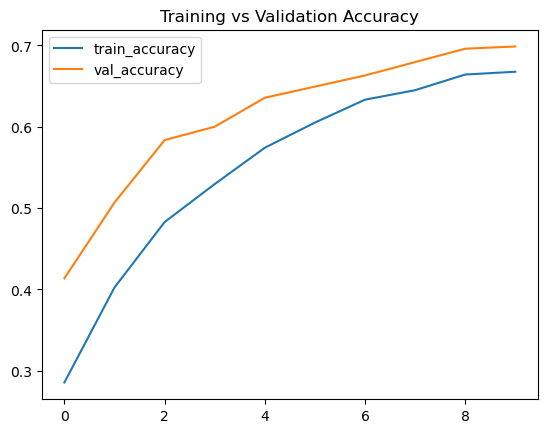

In [29]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

Now we will unfreeze some layers ,lower learning rate , and train again to push accuracy higher.

In [30]:
#Unfreezing last 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable=True
#compiling again with lower training rate 
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#We recompile whenever we change layer trainability

In [31]:
#Fine tune
EPOCHS_FINE_TUNE=10
history_finetune=model.fit(train_generator,
                           epochs=EPOCHS_FINE_TUNE,
                           validation_data=val_generator)
                           

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.5704 - loss: 1.0578 - val_accuracy: 0.7534 - val_loss: 0.7199
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - accuracy: 0.6878 - loss: 0.8190 - val_accuracy: 0.7808 - val_loss: 0.6576
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 262s 6s/step - accuracy: 0.7579 - loss: 0.6537 - val_accuracy: 0.7945 - val_loss: 0.6158
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.7945 - loss: 0.5811 - val_accuracy: 0.8082 - val_loss: 0.5862
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.8408 - loss: 0.4904 - val_accuracy: 0.8055 - val_loss: 0.5685
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step - accuracy: 0.8333 - loss: 0.5174 - val_accuracy: 0.8055 - val_loss: 0.5466
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - accuracy: 0.8502 - loss: 0.4665 - val_accuracy: 0.8055 - val_loss: 0.5386
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.8593 - loss: 0.3993 - val_accuracy: 0.8110 - v

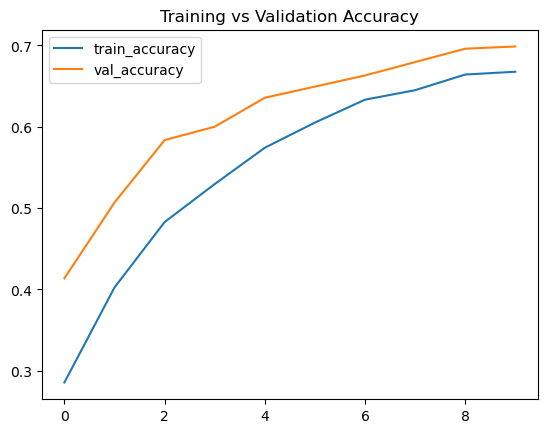

In [32]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Beautiful, our validation accuracy is above 82% . This is way higher than the traditional model


Doing Final evalutaion now (Confusion matrix + Classification Report)

In [33]:
class_labels = ['healthy', 'multiple_diseases', 'rust', 'scab']


12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step
classification report:
                   precision    recall  f1-score   support

          healthy       0.69      0.95      0.80       103
multiple_diseases       1.00      0.06      0.11        18
             rust       0.90      0.91      0.91       125
             scab       0.91      0.73      0.81       119

         accuracy                           0.82       365
        macro avg       0.88      0.66      0.66       365
     weighted avg       0.85      0.82      0.81       365



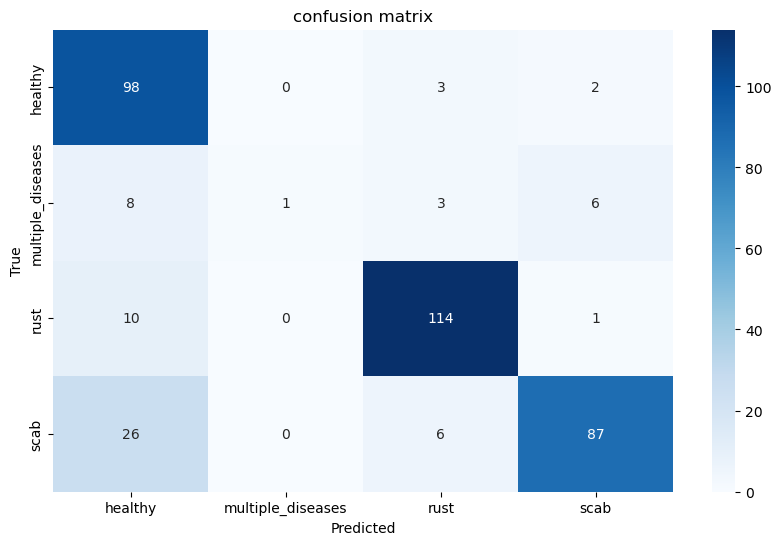

In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#predict on validation set
val_generator.reset()
pred_probs=model.predict(val_generator)
y_pred=np.argmax(pred_probs,axis=1)

#getting true labels
y_true=val_generator.classes

#classification report
print("classification report:")
print(classification_report(y_true,y_pred,target_names=class_labels))

#confusion matrix
cm=confusion_matrix(y_true,y_pred)

#plot confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_labels,yticklabels=class_labels,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('confusion matrix')
plt.show()      

# Now to save our model

In [35]:
# saving entire model (architecture+weights+ optimizer state) This saves only the CNN model
model.save("plant_disease_model.keras")

In [37]:
import joblib
joblib.dump(xgb_final, 'xgboost_58features_model.pkl')


['xgboost_58features_model.pkl']